# Airbus Ship Detection

In [12]:
import os
import random
import math

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split
#from skimage.morphology import label
from tqdm import tqdm


# Define the constants
DATASET_PATH = "/kaggle/input/airbus-ship-detection"
TRAIN_FOLDER = os.path.join(DATASET_PATH, "train_v2")
TEST_FOLDER = os.path.join(DATASET_PATH, "test_v2")
CSV_PATH = os.path.join(DATASET_PATH, "train_ship_segmentations_v2.csv")

# Style the plots and display them inline
plt.style.use("fivethirtyeight")
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define some helper functions for RLE encoding and decoding,
# which will be used later for converting
# the predicted ship masks to the required format

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    Convert run-length encoded mask to a binary mask

    Args:
        mask_rle (str): Run-length encoded mask string
        shape (tuple): Shape of the output binary mask

    Returns:
        numpy.ndarray: Binary mask array
    '''
    # Split the run-length encoded string
    s = mask_rle.split()
    starts = np.asarray(s[0:][::2], dtype=int) - 1
    lengths = np.asarray(s[1:][::2], dtype=int)
    ends = starts + lengths

    # Initialize an array for the binary mask
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # Set the pixels corresponding to the mask region to 1
    for start, end in zip(starts, ends):
        img[start:end] = 1

    # Reshape the array to the desired shape
    return img.reshape(shape).T


def masks_as_image(in_mask_list, dim = (768, 768)):
    '''
    Combine individual ship masks into a single mask array

    Args:
        in_mask_list (list): List of ship masks (run-length encoded strings)

    Returns:
        numpy.ndarray: Combined mask array
    '''
    # Initialize an array to hold the combined mask
    all_masks = np.zeros(dim, dtype=np.int16)

    # Iterate over the ship masks and add them to the combined mask
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)

    # Expand dimensions to match the expected shape
    return np.expand_dims(all_masks, -1)

In [3]:
# Function to view a random image from the training set
def view_random_image(target_dir):
  '''
  View a random image from the specified directory

  Args:
      target_dir (str): Path to the directory containing images

  Returns:
      numpy.ndarray: Image array
  '''
  # Get a random image path
  random_image = random.sample(os.listdir(target_dir), 1)

  # Read in the image and plot it
  img = mpimg.imread(target_dir + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off")

  # Print the shape of the image
  print(f"Image shape: {img.shape}")

  return img


# Dataset

In [4]:
import os

for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 2 images in '/kaggle/input/airbus-ship-detection'.
There are 0 directories and 15606 images in '/kaggle/input/airbus-ship-detection/test_v2'.
There are 0 directories and 192556 images in '/kaggle/input/airbus-ship-detection/train_v2'.


In [5]:
df = pd.read_csv(CSV_PATH)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Image shape: (768, 768, 3)


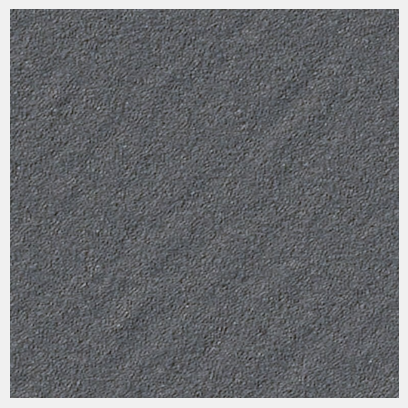

In [6]:
img = view_random_image(TRAIN_FOLDER)

In [7]:
num_images = len(df['ImageId'].unique())
print(f"The number of images in the dataset: {num_images}")

The number of images in the dataset: 192556


In [8]:
num_ships = len(df[df['EncodedPixels'].notna()])
num_non_ships = num_images - num_ships
print('Number of ships:', num_ships)
print('Number of non-ships:', num_non_ships)

Number of ships: 81723
Number of non-ships: 110833


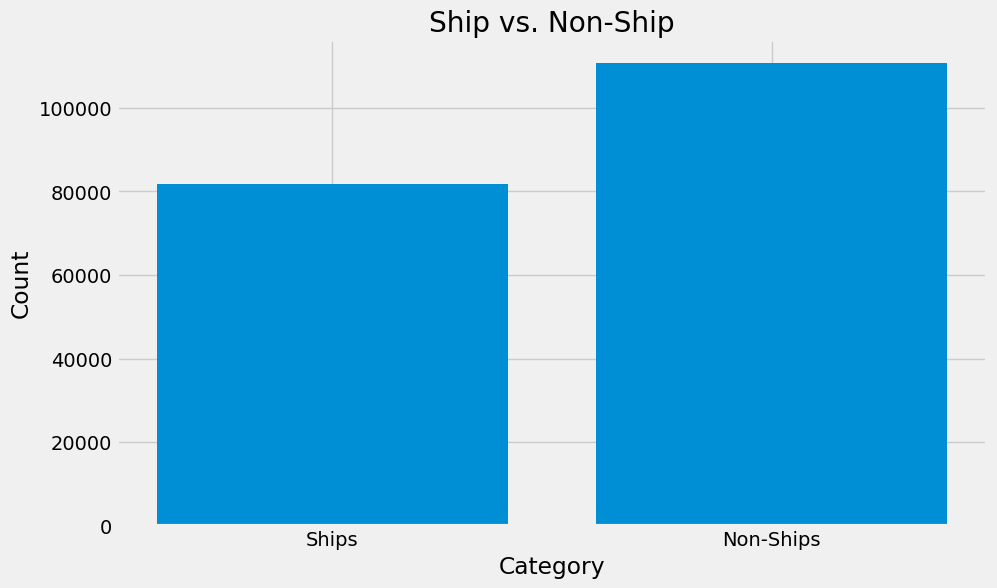

In [9]:
# Plot a bar chart of the ship vs. non-ship distribution
plt.figure(figsize=(10, 6))
plt.bar(['Ships', 'Non-Ships'], [num_ships, num_non_ships])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Ship vs. Non-Ship')
plt.show()

In [10]:
number_of_masks_counts = df["ImageId"].value_counts()
number_of_masks_counts

ImageId
e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: count, Length: 192556, dtype: int64

In [11]:
# Create a copy of the working dataframe
ship_df = df.copy()
ship_df['NumberOfShips'] = ship_df['EncodedPixels'].notnull().astype(int)
ship_df['EncodedPixels'] = ship_df['EncodedPixels'].replace(0, '')
ship_df

,ImageId,EncodedPixels,NumberOfShips
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [12]:
# Group by the image name
ship_df = ship_df.groupby('ImageId').sum().reset_index()
ship_df

,ImageId,EncodedPixels,NumberOfShips
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,0001b1832.jpg,0,0
...,...,...,...
192551,fffedbb6b.jpg,0,0
192552,ffff2aa57.jpg,0,0
192553,ffff6e525.jpg,0,0
192554,ffffc50b4.jpg,0,0


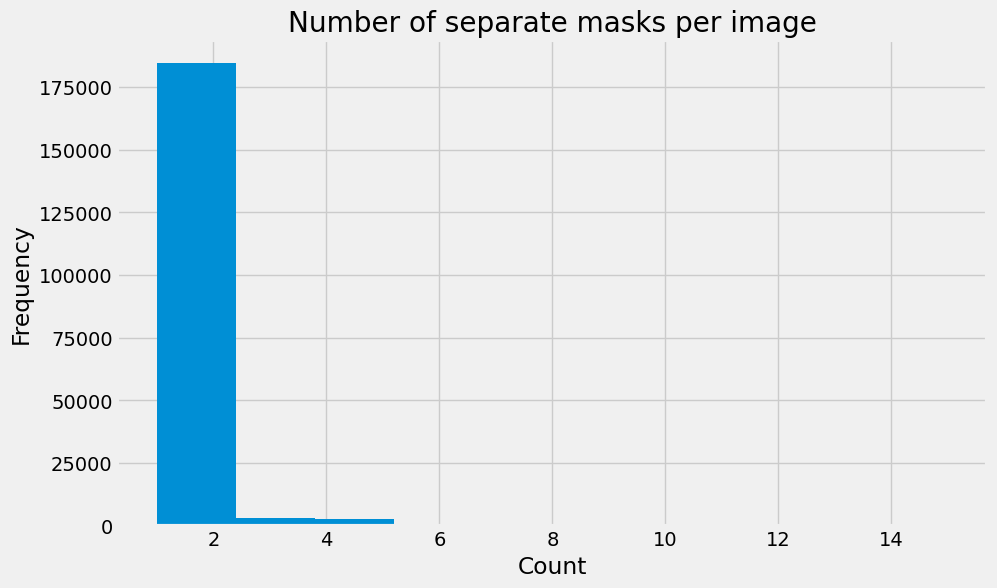

In [13]:
# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(number_of_masks_counts, bins=10)  # Create a histogram with 30 bins
plt.title("Number of separate masks per image")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

# Working with NaNs

In [14]:
rle_with_zeros = rle_encode(np.zeros((768, 768, 1)))
print(rle_with_zeros == "")

True


In [15]:
df = df.fillna("")
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Undersampling negative samples

<Axes: ylabel='Frequency'>

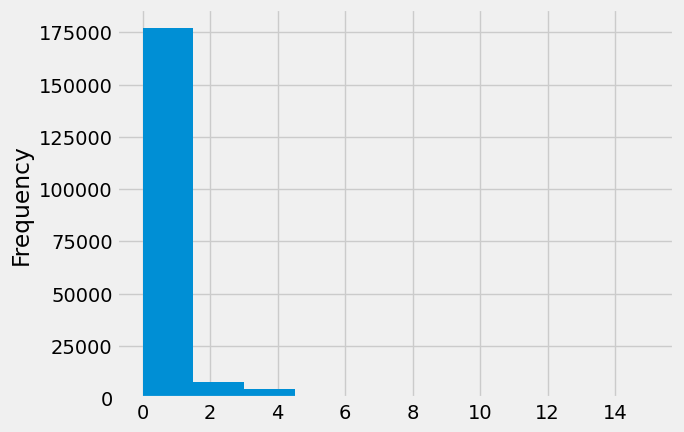

In [16]:
ship_df['NumberOfShips'].plot.hist()

In [17]:
ship_df['NumberOfShips'].value_counts()

NumberOfShips
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: count, dtype: int64

In [18]:
train_ships, valid_ships = train_test_split(ship_df,
                                            test_size = 0.2,
                                            stratify = ship_df['NumberOfShips'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [19]:
train_ships

,ImageId,EncodedPixels,NumberOfShips
67670,5a063d522.jpg,0,0
46686,3e4b49b95.jpg,133290 2 134058 4 134825 7 135593 9 136360 12 ...,1
166781,dde1dae84.jpg,0,0
175031,e8c220222.jpg,0,0
152241,ca78dd727.jpg,97613 7 98381 7 99149 7 99917 7 100685 7 10145...,3
...,...,...,...
113744,973ab3eb2.jpg,0,0
106879,8e15a2de4.jpg,0,0
92660,7b17a79b2.jpg,186975 3 187743 7 188511 12 189278 17 190046 2...,3
19182,197650639.jpg,0,0


In [20]:
valid_ships

,ImageId,EncodedPixels,NumberOfShips
35926,2fbc0cf98.jpg,0,0
102947,88e7a213d.jpg,0,0
116737,9b28bfc29.jpg,0,0
46089,3d796959b.jpg,0,0
18855,1911d1261.jpg,476654 2 477418 6 478182 10 478946 15 479710 1...,1
...,...,...,...
65526,573ce9221.jpg,0,0
79837,6a06371dd.jpg,0,0
65432,5722b7ecf.jpg,25092 2 25858 4 26625 6 27393 6 28162 6 28930 ...,1
29712,277431a71.jpg,0,0


In [21]:
def undersample_zeros(df, n):
    zeros = df[df['NumberOfShips'] == 0].sample(n=n)
    nonzeros = df[df['NumberOfShips'] != 0]
    return pd.concat((nonzeros, zeros))

<Axes: ylabel='Frequency'>

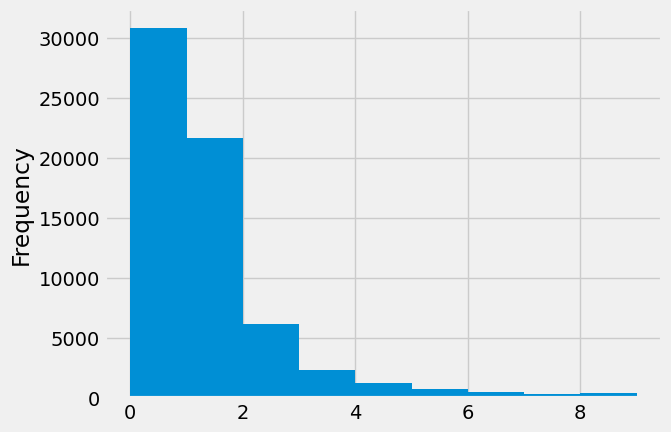

In [22]:
PERCENTAGE_WITHOUT_SHIPS = 0.2
train_ships = undersample_zeros(train_ships, int(len(train_ships) * PERCENTAGE_WITHOUT_SHIPS))
valid_ships = undersample_zeros(valid_ships, int(len(valid_ships) * PERCENTAGE_WITHOUT_SHIPS))
train_ships['NumberOfShips'].plot.hist(bins=np.arange(10))

<Axes: xlabel='NumberOfShips'>

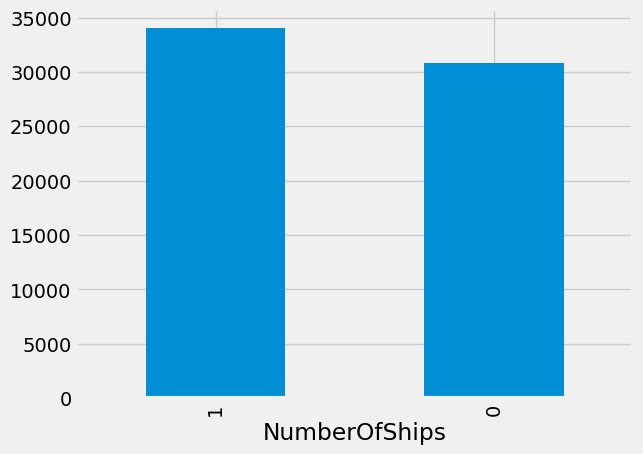

In [23]:
(train_ships['NumberOfShips'] > 0).astype(int).value_counts().plot.bar()

<Axes: xlabel='NumberOfShips'>

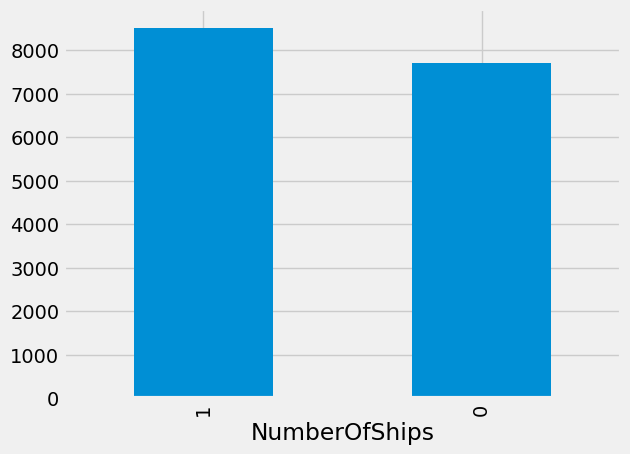

In [24]:
(valid_ships['NumberOfShips'] > 0).astype(int).value_counts().plot.bar()

In [25]:
def show(image, mask):
    print(image.shape)
    print(mask.shape)
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Display ground truth mask
    plt.subplot(1, 2, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Display BGR image
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Show the plot
    plt.show()

(768, 768, 3)
(768, 768, 1)


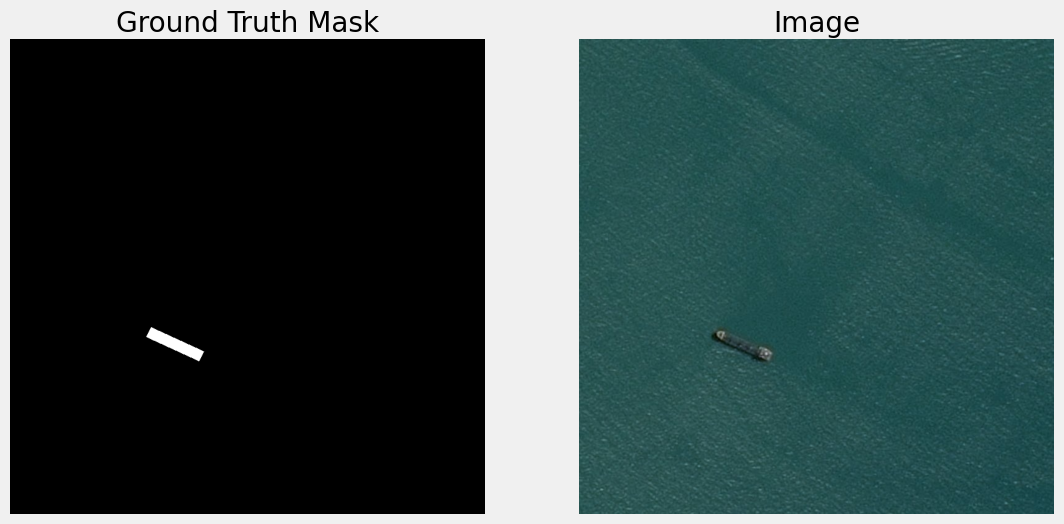

In [26]:
import cv2

image_name = np.random.choice(np.array(train_ships['ImageId']))
image_path = os.path.join(TRAIN_FOLDER, image_name)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = masks_as_image(df[df['ImageId'] == image_name]['EncodedPixels'])
show(image, mask)

# Train Unet + Mix Vision Transformer

In [2]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-pj_q95d2
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-pj_q95d2
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.7 from https://files.pythonhosted.org/packages/7a/bd/2c56be7a3b5bc71cf85a405246b89d5359f942c9f7fb6db6306d9d056092/timm-0.9.7-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhoste

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

train_dim = (544, 544)

ENCODER = 'mit_b0'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['ship']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
BATCH_SIZE = 16

In [29]:
import albumentations as albu


def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        #albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [30]:
class Dataset(BaseDataset):

    CLASSES = ['ship']

    def __init__(
            self,
            images_set,
            masks_set,
            train_dim,
            augmentation=None,
            preprocessing=None
    ):
        self.images = images_set
        self.masks = masks_set
        self.class_values = [1]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.train_dim = train_dim

    def __getitem__(self, i):
        image_path = os.path.join(TRAIN_FOLDER, self.images[i])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = masks_as_image(self.masks[self.masks['ImageId'] == self.images[i]]['EncodedPixels'])

        image = cv2.resize(image, self.train_dim, interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, self.train_dim, interpolation = cv2.INTER_AREA)

        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images)

In [31]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b0.pth" to /root/.cache/torch/hub/checkpoints/mit_b0.pth
100%|██████████| 13.7M/13.7M [00:00<00:00, 181MB/s]


In [32]:
train_dataset = Dataset(
    np.array(train_ships['ImageId']),
    df,
    train_dim,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    np.array(valid_ships['ImageId']),
    df,
    train_dim,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [34]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [35]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [36]:
max_score = 0
EPOCHS = 1
weights_dir = "weights"
os.makedirs(weights_dir, exist_ok=True)

for epoch in range(0, EPOCHS):

    print(f'Epoch: {epoch}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(weights_dir, f"{ENCODER}_{epoch}_epoch.pth"))
        print('Model saved!')

    if epoch == EPOCHS - 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

Epoch: 0
valid: 100%|██████████| 1014/1014 [08:45<00:00,  1.93it/s, dice_loss - 0.5594, iou_score - 0.769] 
Model saved!


# Testing trained model

In [5]:
import os
import time
import glob
import random

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

In [9]:
class ShipSegmentation:

    def __init__(self, model_path, device, encoder='mit_b0', encoder_weights='imagenet'):
        self.device = device
        self._model = self._load_model(model_path)
        self._encoder = encoder
        self._encoder_weights = encoder_weights
        preprocessing_fn = smp.encoders.get_preprocessing_fn(self._encoder, self._encoder_weights)
        self.model_preprocessing = self._get_preprocessing(preprocessing_fn)

    def _load_model(self, model_path):
        model = torch.load(model_path, map_location=self.device)
        model.to(self.device)
        model.eval()
        return model


    def _to_tensor(self, x):
        return x.transpose(2, 0, 1).astype('float32')

    def _get_preprocessing(self, preprocessing_fn):
        _transform = [
            transforms.Lambda(lambda x: preprocessing_fn(x)),
            transforms.Lambda(lambda x: self._to_tensor(x)),
        ]
        return transforms.Compose(_transform)
    
    def preprocessing(self, image):
        dim = (544, 544)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image = self.model_preprocessing(image)
        return torch.from_numpy(image).to(self.device).unsqueeze(0)
    
    def predict(self, orig_image):
        image = self.preprocessing(orig_image)
        ship_mask = self._model.predict(image)
        ship_mask = (ship_mask.squeeze().cpu().numpy().round() * 255).astype(np.uint8)
        ship_mask = cv2.resize(ship_mask, orig_image.shape[:2][::-1], interpolation = cv2.INTER_AREA)
        return ship_mask

In [10]:
def show(rgb_image, predicted_mask):
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Display RGB image
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title('Image')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Show the plot
    plt.show()

In [13]:
from tqdm import tqdm  

output_folder = "/kaggle/working/output"
os.makedirs(output_folder, exist_ok=True)

weights_dir = "/kaggle/input/weights-dir/weights"
model_path = os.path.join(weights_dir, "mit_b0_93_epoch.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ship = ShipSegmentation(model_path=model_path, device=device)

images = os.listdir(TEST_FOLDER)
images = random.sample(images, 500)

for image_name in tqdm(images):
    bgr_image = cv2.imread(os.path.join(TEST_FOLDER, image_name))
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    predicted_mask = ship.predict(rgb_image)
    predicted_mask = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2BGR)

    #show(rgb_image, predicted_mask)
    cv2.imwrite(os.path.join(output_folder, image_name), np.hstack((bgr_image, predicted_mask)))

100%|██████████| 500/500 [00:42<00:00, 11.87it/s]


In [14]:
!zip -r {output_folder}.zip {output_folder}

  adding: kaggle/working/output/ (stored 0%)
  adding: kaggle/working/output/f2c5c8851.jpg (deflated 8%)
  adding: kaggle/working/output/352ef528b.jpg (deflated 8%)
  adding: kaggle/working/output/3b31feab6.jpg (deflated 9%)
  adding: kaggle/working/output/18f715cfe.jpg (deflated 9%)
  adding: kaggle/working/output/8fe79acb6.jpg (deflated 10%)
  adding: kaggle/working/output/40bd93a1c.jpg (deflated 7%)
  adding: kaggle/working/output/4d775ec97.jpg (deflated 8%)
  adding: kaggle/working/output/7fd1aa69e.jpg (deflated 12%)
  adding: kaggle/working/output/f8c9def64.jpg (deflated 8%)
  adding: kaggle/working/output/89ba2dbf7.jpg (deflated 7%)
  adding: kaggle/working/output/01fc15d21.jpg (deflated 7%)
  adding: kaggle/working/output/898837df3.jpg (deflated 12%)
  adding: kaggle/working/output/0089d5f39.jpg (deflated 9%)
  adding: kaggle/working/output/dc9d9aeb0.jpg (deflated 7%)
  adding: kaggle/working/output/855b3ecfb.jpg (deflated 9%)
  adding: kaggle/working/output/fb8e46be0.jpg (defla